<a href="https://colab.research.google.com/github/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/blob/main/HW/HW5/Prac/Interpretability_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpretability

##  Covid Image Classification Using ResNet and Inference
COVID-19 detection models utilizing CT images involve the application of machine learning algorithms to analyze chest X-ray images, aiming to identify patterns and features associated with COVID-19 infections. The provided [dataset](https://www.kaggle.com/datasets/plameneduardo/a-covid-multiclass-dataset-of-ct-scans/) comprises 4173 CT scan images of the lungs (Chest CT Scan) with three different classes, including Covid, Healthy, and Others. Our focus for this assignment is solely on the first two classes.*italicized text*

### Download the Dataset

You can download the dataset of this relevant exercise using the code snippet below. Just note that you need to create an account in Kaggle first and then follow the steps below to receive your `kaggle.json` file and then upload it below:
1. Go to your Kaggle account, Scroll to the API section, and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download the `kaggle.json` file on your machine.

If you need more details to read, you can refer to this [link](https://www.kaggle.com/discussions/general/156610).


In [ ]:
# from google.colab import files

In [ ]:
# files.upload()

In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import json
! pip install kaggle
! mkdir -p ~/.kaggle
# create kaggale.json file
json.dump({"username":"amirkasaei","key":"8e285e5c5c2d8511eefcb41b5abc4668"}, open('kaggle.json', 'w'))
! mv ./kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download plameneduardo/a-covid-multiclass-dataset-of-ct-scans/

100% 405M/405M [00:04<00:00, 122MB/s]
100% 405M/405M [00:04<00:00, 96.8MB/s]


In [ ]:
!unzip ./a-covid-multiclass-dataset-of-ct-scans.zip

In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Preprocessing

* The existing data structure consists of patient-wise subfolders. Thus, the initial step involves copying all images into the Covid, Healthy, and Other folders while eliminating any subfolders.

In [ ]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import numpy as np
from sklearn import utils
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

 Creating ./data with its subfolders, splitting the files, and saving each file to its respective directory.

In [ ]:
!mkdir ./data
!mkdir ./data/train
!mkdir ./data/test
!mkdir ./data/train/covid
!mkdir ./data/train/healthy
!mkdir ./data/test/covid
!mkdir ./data/test/healthy

In [ ]:
def copyfiles(source, dest):
    file_names = []
    for foldername, subfolders, filenames in os.walk(source):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            file_names.append(file_path)

    train_files, test_files = train_test_split(file_names, test_size=0.2, random_state=42)
    for file_path in train_files:
        shutil.copy(file_path, os.path.join('./data/train' + dest, os.path.basename(file_path)))
    for file_path in test_files:
        shutil.copy(file_path, os.path.join('./data/test' + dest, os.path.basename(file_path)))

copyfiles('./New_Data_CoV2/Covid', '/covid')
copyfiles('./New_Data_CoV2/Healthy', '/healthy')

In [ ]:
def count_files(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

print('The total number of files in trainset:',  count_files('./data/train/'))
print('The total number of files in testset:',  count_files('./data/test/'))

The total number of files in trainset: 2066
The total number of files in testset: 532


Visualize the dataset and plot some randomly selected sample images from the data.

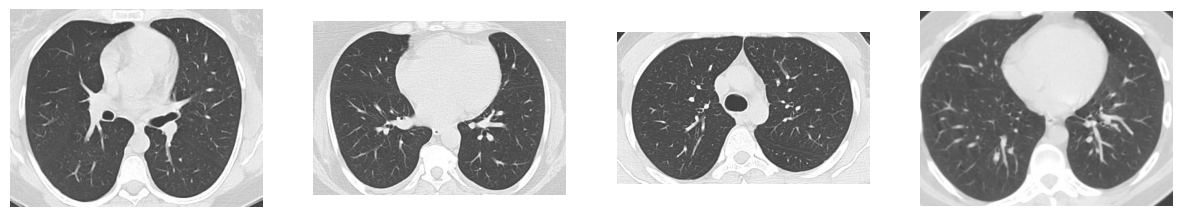

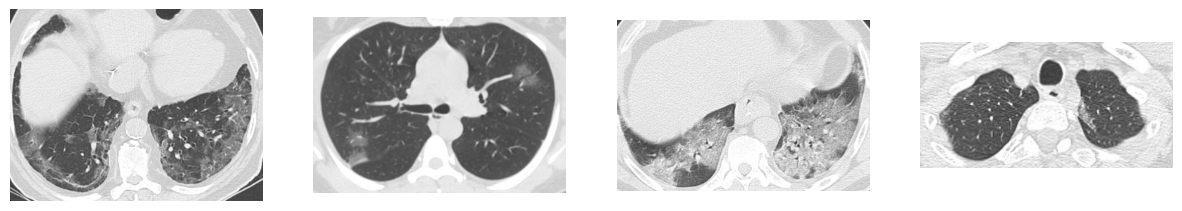

In [ ]:
def plot_images_in_row(folder_path, num_images=4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 3))

    for i, image_file in enumerate(selected_images, start=1):
        plt.subplot(1, num_images, i)
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

covid_folder = './data/train/covid'
healthy_folder = './data/train/healthy'

plot_images_in_row(healthy_folder)
plot_images_in_row(covid_folder)

Create data loaders and apply preprocessing techniques, as well as augmentation and transformation methods, to enhance the model's performance. Also, split the data into train and test sets.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 16

covid_train = os.listdir('./data/train/covid')
healthy_train = os.listdir('./data/train/healthy')

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform_test)

class_counts = [covid_train, healthy_train]
total_samples = sum(map(len, class_counts))
class_freq = [len(class_sample) / total_samples for class_sample in class_counts]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### ResNet

In [ ]:
resnet_model = models.resnet18(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model = resnet_model.to(device)

class_weights = torch.FloatTensor([1.0 / freq for freq in class_freq]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def fit_model(epochs, model, criterion, optimizer, Train, Test):

    train_acc, train_loss = [], []
    test_acc, test_loss = [], []

    for epoch in range(epochs):
        epoch_acc, epoch_loss = 0, 0
        model = model.train()

        with tqdm.tqdm(enumerate(Train), total=len(Train)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)
                epoch_acc += (pred.t() == labels).sum().item()

        train_loss.append(epoch_loss/(i+1))
        train_acc.append(epoch_acc/len(Train.dataset))

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Train.dataset)))

        epoch_acc, epoch_loss = 0, 0
        model.eval()

        with tqdm.tqdm(enumerate(Test), total=len(Test)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)

                epoch_acc += (pred.t() == labels).sum().item()

        test_loss.append(epoch_loss/(i+1))
        test_acc.append(epoch_acc/len(Test.dataset))

        print('Epoch: %d | Loss: %.4f | Test Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Test.dataset)))

    return train_loss, train_acc, test_loss, test_acc


In [ ]:
epochs = 40
train_loss , train_acc, test_loss, test_acc = fit_model(epochs, resnet_model,
                                                        criterion, optimizer,
                                                        train_loader, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 65/65 [00:11<00:00,  5.43it/s]

Epoch: 0 | Loss: 0.2117 | Train Accuracy: 0.8925



100%|██████████| 17/17 [00:02<00:00,  6.87it/s]

Epoch: 0 | Loss: 0.2170 | Test Accuracy: 0.8964



100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

Epoch: 1 | Loss: 0.0680 | Train Accuracy: 0.9748



100%|██████████| 17/17 [00:02<00:00,  6.87it/s]

Epoch: 1 | Loss: 0.1600 | Test Accuracy: 0.9510



100%|██████████| 65/65 [00:11<00:00,  5.49it/s]

Epoch: 2 | Loss: 0.0567 | Train Accuracy: 0.9801



100%|██████████| 17/17 [00:02<00:00,  6.94it/s]

Epoch: 2 | Loss: 0.0881 | Test Accuracy: 0.9680



100%|██████████| 65/65 [00:11<00:00,  5.54it/s]

Epoch: 3 | Loss: 0.0446 | Train Accuracy: 0.9845



100%|██████████| 17/17 [00:02<00:00,  6.29it/s]

Epoch: 3 | Loss: 0.0979 | Test Accuracy: 0.9661



100%|██████████| 65/65 [00:11<00:00,  5.69it/s]

Epoch: 4 | Loss: 0.0227 | Train Accuracy: 0.9932



100%|██████████| 17/17 [00:03<00:00,  4.61it/s]

Epoch: 4 | Loss: 0.0699 | Test Accuracy: 0.9812



100%|██████████| 65/65 [00:11<00:00,  5.68it/s]

Epoch: 5 | Loss: 0.0091 | Train Accuracy: 0.9981



100%|██████████| 17/17 [00:02<00:00,  6.20it/s]

Epoch: 5 | Loss: 0.0639 | Test Accuracy: 0.9755



100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

Epoch: 6 | Loss: 0.0254 | Train Accuracy: 0.9923



100%|██████████| 17/17 [00:02<00:00,  6.92it/s]

Epoch: 6 | Loss: 0.0466 | Test Accuracy: 0.9887



100%|██████████| 65/65 [00:11<00:00,  5.57it/s]

Epoch: 7 | Loss: 0.0400 | Train Accuracy: 0.9874



100%|██████████| 17/17 [00:02<00:00,  6.93it/s]

Epoch: 7 | Loss: 0.1215 | Test Accuracy: 0.9812



100%|██████████| 65/65 [00:11<00:00,  5.52it/s]

Epoch: 8 | Loss: 0.0222 | Train Accuracy: 0.9932



100%|██████████| 17/17 [00:02<00:00,  6.85it/s]

Epoch: 8 | Loss: 0.0405 | Test Accuracy: 0.9849



100%|██████████| 65/65 [00:11<00:00,  5.54it/s]

Epoch: 9 | Loss: 0.0299 | Train Accuracy: 0.9913



100%|██████████| 17/17 [00:02<00:00,  6.92it/s]

Epoch: 9 | Loss: 0.0373 | Test Accuracy: 0.9812



100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

Epoch: 10 | Loss: 0.0131 | Train Accuracy: 0.9956



100%|██████████| 17/17 [00:02<00:00,  6.67it/s]

Epoch: 10 | Loss: 0.0464 | Test Accuracy: 0.9774



100%|██████████| 65/65 [00:12<00:00,  5.01it/s]

Epoch: 11 | Loss: 0.0027 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:03<00:00,  4.75it/s]

Epoch: 11 | Loss: 0.0396 | Test Accuracy: 0.9849



100%|██████████| 65/65 [00:11<00:00,  5.78it/s]

Epoch: 12 | Loss: 0.0030 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  6.18it/s]

Epoch: 12 | Loss: 0.0365 | Test Accuracy: 0.9849



100%|██████████| 65/65 [00:12<00:00,  5.30it/s]

Epoch: 13 | Loss: 0.0096 | Train Accuracy: 0.9971



100%|██████████| 17/17 [00:02<00:00,  6.91it/s]

Epoch: 13 | Loss: 0.0526 | Test Accuracy: 0.9831



100%|██████████| 65/65 [00:11<00:00,  5.50it/s]

Epoch: 14 | Loss: 0.0122 | Train Accuracy: 0.9956



100%|██████████| 17/17 [00:02<00:00,  6.82it/s]

Epoch: 14 | Loss: 0.0302 | Test Accuracy: 0.9906



100%|██████████| 65/65 [00:11<00:00,  5.56it/s]

Epoch: 15 | Loss: 0.0118 | Train Accuracy: 0.9961



100%|██████████| 17/17 [00:02<00:00,  6.77it/s]

Epoch: 15 | Loss: 0.0601 | Test Accuracy: 0.9812



100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

Epoch: 16 | Loss: 0.0049 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  6.77it/s]

Epoch: 16 | Loss: 0.0472 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.58it/s]

Epoch: 17 | Loss: 0.0089 | Train Accuracy: 0.9976



100%|██████████| 17/17 [00:02<00:00,  6.39it/s]

Epoch: 17 | Loss: 0.0688 | Test Accuracy: 0.9831



100%|██████████| 65/65 [00:11<00:00,  5.72it/s]

Epoch: 18 | Loss: 0.0095 | Train Accuracy: 0.9961



100%|██████████| 17/17 [00:03<00:00,  4.61it/s]

Epoch: 18 | Loss: 0.0610 | Test Accuracy: 0.9831



100%|██████████| 65/65 [00:11<00:00,  5.85it/s]

Epoch: 19 | Loss: 0.0018 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  5.67it/s]

Epoch: 19 | Loss: 0.0700 | Test Accuracy: 0.9793



100%|██████████| 65/65 [00:11<00:00,  5.57it/s]

Epoch: 20 | Loss: 0.0023 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  6.69it/s]

Epoch: 20 | Loss: 0.0539 | Test Accuracy: 0.9793



100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

Epoch: 21 | Loss: 0.0011 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.59it/s]

Epoch: 21 | Loss: 0.0448 | Test Accuracy: 0.9793



100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

Epoch: 22 | Loss: 0.0008 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.70it/s]

Epoch: 22 | Loss: 0.0401 | Test Accuracy: 0.9887



100%|██████████| 65/65 [00:11<00:00,  5.50it/s]

Epoch: 23 | Loss: 0.0005 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.92it/s]

Epoch: 23 | Loss: 0.0452 | Test Accuracy: 0.9831



100%|██████████| 65/65 [00:11<00:00,  5.52it/s]

Epoch: 24 | Loss: 0.0009 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.82it/s]

Epoch: 24 | Loss: 0.0426 | Test Accuracy: 0.9849



100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

Epoch: 25 | Loss: 0.0002 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:03<00:00,  5.11it/s]

Epoch: 25 | Loss: 0.0346 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:10<00:00,  5.95it/s]

Epoch: 26 | Loss: 0.0004 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:04<00:00,  4.04it/s]

Epoch: 26 | Loss: 0.0400 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

Epoch: 27 | Loss: 0.0004 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.86it/s]

Epoch: 27 | Loss: 0.0416 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

Epoch: 28 | Loss: 0.0002 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.73it/s]

Epoch: 28 | Loss: 0.0362 | Test Accuracy: 0.9887



100%|██████████| 65/65 [00:11<00:00,  5.55it/s]

Epoch: 29 | Loss: 0.0002 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.95it/s]

Epoch: 29 | Loss: 0.0337 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.47it/s]

Epoch: 30 | Loss: 0.0014 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  6.92it/s]

Epoch: 30 | Loss: 0.0558 | Test Accuracy: 0.9887



100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

Epoch: 31 | Loss: 0.0006 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.63it/s]

Epoch: 31 | Loss: 0.0486 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.64it/s]

Epoch: 32 | Loss: 0.0004 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:03<00:00,  4.67it/s]

Epoch: 32 | Loss: 0.0413 | Test Accuracy: 0.9887



100%|██████████| 65/65 [00:11<00:00,  5.83it/s]

Epoch: 33 | Loss: 0.0005 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.20it/s]

Epoch: 33 | Loss: 0.0397 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.54it/s]

Epoch: 34 | Loss: 0.0002 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.74it/s]

Epoch: 34 | Loss: 0.0360 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.54it/s]

Epoch: 35 | Loss: 0.0085 | Train Accuracy: 0.9971



100%|██████████| 17/17 [00:02<00:00,  6.89it/s]

Epoch: 35 | Loss: 0.0647 | Test Accuracy: 0.9774



100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

Epoch: 36 | Loss: 0.0797 | Train Accuracy: 0.9777



100%|██████████| 17/17 [00:02<00:00,  6.75it/s]

Epoch: 36 | Loss: 0.6567 | Test Accuracy: 0.8399



100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

Epoch: 37 | Loss: 0.0664 | Train Accuracy: 0.9719



100%|██████████| 17/17 [00:02<00:00,  6.76it/s]

Epoch: 37 | Loss: 0.2500 | Test Accuracy: 0.9529



100%|██████████| 65/65 [00:11<00:00,  5.49it/s]

Epoch: 38 | Loss: 0.0226 | Train Accuracy: 0.9927



100%|██████████| 17/17 [00:02<00:00,  6.85it/s]

Epoch: 38 | Loss: 0.0535 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

Epoch: 39 | Loss: 0.0131 | Train Accuracy: 0.9932



100%|██████████| 17/17 [00:03<00:00,  4.73it/s]

Epoch: 39 | Loss: 0.0243 | Test Accuracy: 0.9944


Plot Accuracy and Loss plots for both training and validation parts.

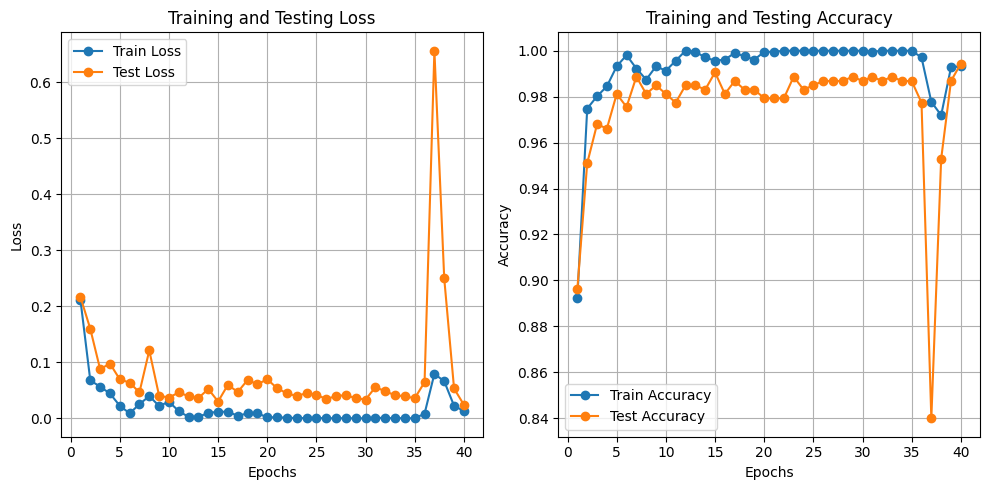

In [ ]:
epochs = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='o')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretability
Here, we aim to select an interpretability algorithm that aids in comprehending the model's decision-making process, debugging, and explaining predictions to non-technical stakeholders. Let's opt for the [Grad-CAM](https://arxiv.org/abs/1610.02391) technique. Grad-CAM, short for Gradient-weighted Class Activation Mapping, highlights important regions in an image that contribute to the model's prediction. This is achieved by computing the gradients of the target class with respect to the final convolutional layer.

[GradCam github](https://github.com/jacobgil/pytorch-grad-cam)

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used in computer vision to interpret and visualize the decisions made by deep neural networks, particularly convolutional neural networks (CNNs). It highlights important regions in an input image for a specific class prediction. The process involves a feedforward pass, gradient calculation with respect to the target class, global average pooling, and generating an activation map that visually indicates significant regions in the input image for the predicted class. Grad-CAM enhances the interpretability of neural networks by showing which parts of an image contribute most to a model's decision-making. It works by:

1. Forward propagating the input image through the network.
2. Computing the gradients of the score for the class of interest with respect to the feature maps of the last convolutional layer.
3. Globally average-pooling these gradients to obtain the neuron importance weights.
4. Computing a weighted combination of the feature maps from the last convolutional layer using these weights.
5. Passing the resulting coarse localization map through a ReLU activation function.

The final output is a heatmap that can be overlaid on the original image to visualize the areas that the model considers important for its prediction. This technique is model-agnostic and can be applied to any CNN-based architecture. However, it may not always accurately reflect the model's decision-making process. It's a useful tool for getting insights into what your model is looking at when making a prediction.

**GradCam usage**:

In [ ]:
'''
  Initially, it is crucial to ensure that the model is in Evaluation mode.
  Failing to do so during result verification could inadvertently alter the
  model's weights, leading to inaccurate and unreliable results.
'''
resnet_model.eval()
device = "cpu"
resnet_model.to(device)

**For this, use the 4th layer of your trained Resent**.

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import to_pil_image


def plot_GradCam(model, image):
    target_layers = [model.layer4[-1]]
    input_tensor = torch.unsqueeze(image, dim=0)
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(1)] # one class

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    img = np.array(to_pil_image(image))/255

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    return grayscale_cam, visualization


Visualize GradCAM heatmaps for 10 images and interpret your model's performance and identify areas your model is paying attention to based on the GradCAM output. For this, use the function you wrote in the previous section.

In [ ]:
label = {
  0: 'Covid',
  1: 'Healthy'
}

In [ ]:
covid_indicies, healthy_indicies = [], []

for i, sample in enumerate(train_dataset):
  if sample[1] == 0:
    covid_indicies.append(i)
  else:
    healthy_indicies.append(i)


In [ ]:
k=10
indicies = np.append(np.random.choice(covid_indicies, 5), np.random.choice(healthy_indicies, 5),0)
np.random.shuffle(indicies)

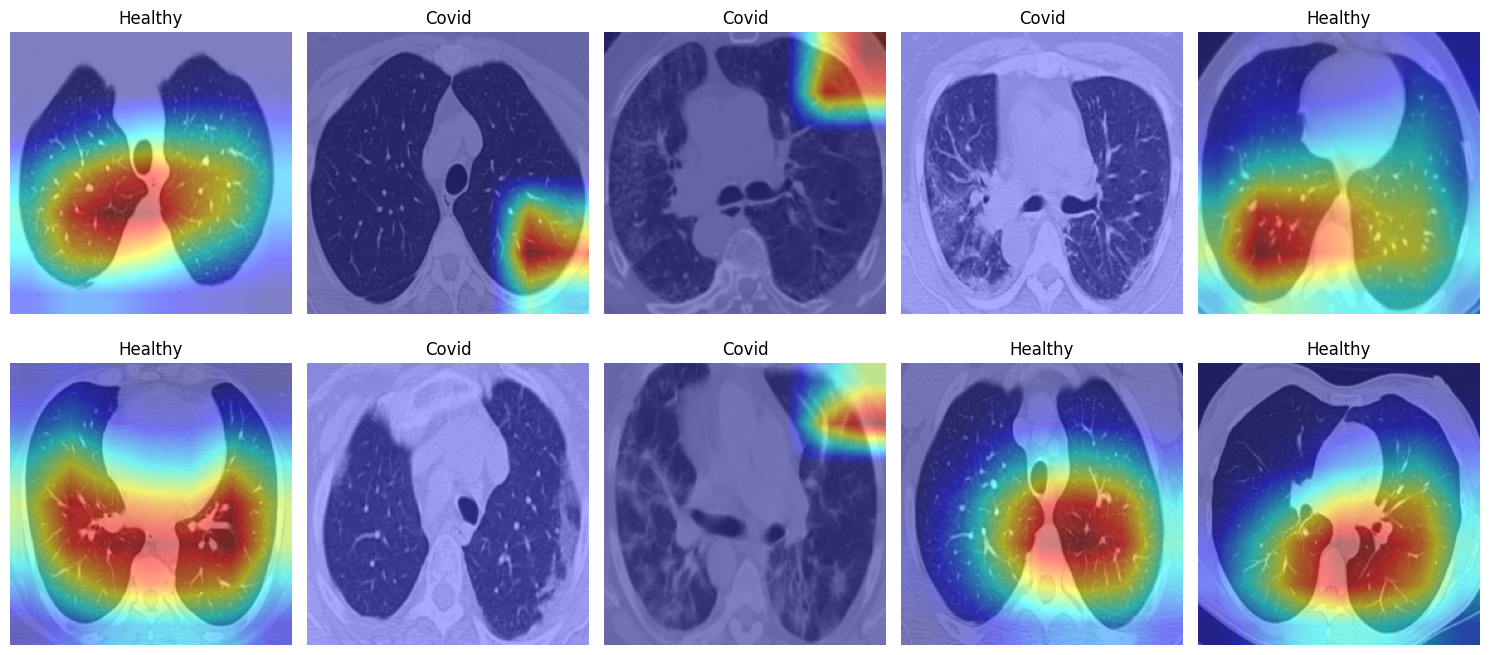

In [ ]:
fig,axs = plt.subplots(2,5, figsize=(15,7))
idx=0

for i, ax in enumerate(axs.flatten()):
  sample = train_dataset[indicies[idx]]
  grayscale_cam, vis = plot_GradCam(resnet_model, sample[0])
  ax.imshow(vis)
  ax.axis("off")
  ax.title.set_text(label[sample[1]])
  idx += 1

plt.tight_layout()
plt.show()

# References
- [pytorch gradcam book](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html)